# Standard Approach for Kaggle

This kernel contains the following processes.
1. Features Engineering
1. Classifier Comparison
1. Grid Search CV

This kernel is inspired by the following ones.  
https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83  
https://www.kaggle.com/sinakhorami/titanic-best-working-classifier?scriptVersionId=566580  

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re

## Loading datasets

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
data = train.append(test) # The entire data: train + test.

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


# Features Engineering

## 1. Pclass ##
There is no missing value on this feature.

## 2. Sex ##
There is no missing value on this feature, but mapping is needed.

In [3]:
train['Sex'].replace(['male','female'],[0,1], inplace=True)
test['Sex'].replace(['male','female'],[0,1], inplace=True)

## 3. SibSp and Parch ##
Create new feature called Family Size, just Parch + SibSp.

In [4]:
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1

train['Family_Size'] = data['Family_Size'][:len(train)]
test['Family_Size'] = data['Family_Size'][len(train):]

Let's go further and categorize people to check whether they are alone in this ship or not.

In [5]:
data['IsAlone'] = 0
data.loc[data['Family_Size'] == 1, 'IsAlone'] = 1

train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

## 4. Embarked ##
Embarked feature has some missing values, filled with the most occurred value ( 'S' ).

In [6]:
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train['Embarked'] = data['Embarked'][:len(train)]
test['Embarked'] = data['Embarked'][len(train):]

## 5. Fare ##
Fare also has some missing value and replaced them with mean, and categorized into 4 ranges.

In [7]:
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
data['Categorical_Fare'] = pd.qcut(data['Fare'], 4, labels=False)

train['Categorical_Fare'] = data['Categorical_Fare'][:len(train)]
test['Categorical_Fare'] = data['Categorical_Fare'][len(train):]

## 6. Age ##
There are plenty of missing values in this feature. Generate random numbers between (mean - std) and (mean + std), categorized into 5 range.

In [8]:
age_avg = data['Age'].mean()
age_std = data['Age'].std()

data['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)
data['Categorical_Age'] = pd.cut(data['Age'], 5, labels=False)

train['Categorical_Age'] = data['Categorical_Age'][:len(train)]
test['Categorical_Age'] = data['Categorical_Age'][len(train):]

## 7. Name ##
Inside this feature, there are titles of people.

In [9]:
# Dropping Title feature
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

data['Title'] = data['Name'].apply(get_title)

data['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare', inplace=True)

data['Title'].replace(['Mlle','Ms','Mme'],['Miss','Miss','Mrs'], inplace=True)

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
data['Title'] = data['Title'].map(title_mapping)
data['Title'].fillna(0, inplace=True)

## 8. Family_Survival ##
This feature is from [S.Xu's kernel](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever).

In [10]:
data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])
data['Fare'].fillna(data['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data.loc[data['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [11]:
for _, grp_df in data.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data[data['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train['Family_Survival'] = data['Family_Survival'][:len(train)]
test['Family_Survival'] = data['Family_Survival'][len(train):]

Number of passenger with family/group survival information: 546


## Data Cleaning ##

In [12]:
delete_columns = ['Fare', 'Age', 'Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
train.drop(delete_columns, axis = 1, inplace = True)
test.drop(delete_columns, axis = 1, inplace = True)

In [13]:
train.head()

,Survived,Pclass,Sex,Embarked,Family_Size,IsAlone,Categorical_Fare,Categorical_Age,Family_Survival
0,0,3,0,0,2,0,0,1,0.5
1,1,1,1,1,2,0,3,2,0.5
2,1,3,1,0,1,1,1,1,0.5
3,1,1,1,0,2,0,3,2,0.0
4,0,3,0,0,1,1,1,2,0.5


# Classifier Comparison #

 - **Creating X and y**

In [14]:
X = train.drop('Survived', axis = 1)
y = train['Survived']
X_test = test.copy()

 - **Scaling features**

In [15]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default 

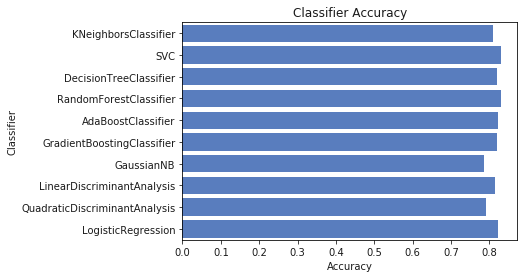

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(10),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

train = train.values
test  = test.values
X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [17]:
log

,Classifier,Accuracy
0,KNeighborsClassifier,0.810000
0,SVC,0.831111
0,DecisionTreeClassifier,0.821111
0,RandomForestClassifier,0.831111
0,AdaBoostClassifier,0.823333
0,GradientBoostingClassifier,0.821111
0,GaussianNB,0.786667
0,LinearDiscriminantAnalysis,0.814444
0,QuadraticDiscriminantAnalysis,0.791111
0,LogisticRegression,0.823333


## Grid Search CV ##
 
 Here I use KNN.

In [18]:
from sklearn.model_selection import GridSearchCV

n_neighbors = list(range(5,20,1))
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc", n_jobs=10)
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=10)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 1620 tasks      | elapsed:    7.1s


0.862053788854
KNeighborsClassifier(algorithm='auto', leaf_size=6, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')


[Parallel(n_jobs=10)]: Done 3000 out of 3000 | elapsed:   11.0s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:718: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 - **Using a model found by grid searching**

In [19]:
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(test)

- **Making submission**

In [27]:
temp = pd.DataFrame(pd.read_csv("../input/test.csv")['PassengerId'])
temp['Survived'] = list(map(int, y_pred))
temp.to_csv("submission.csv", index = False)